Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [62]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import math

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [5]:
def displayTrainCurves(steps, train_loss, train_acc, val_acc):
    f = plt.figure()
    f.add_subplot(2, 1, 1)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.plot(steps, train_loss, 'ro-')
    f.add_subplot(2, 1, 2)
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.plot(steps, train_acc, 'go-', steps, val_acc, 'ro-')
    plt.show()

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [6]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 3.428639
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 100: 1.191936
Minibatch accuracy: 50.0%
Validation accuracy: 64.1%
Minibatch loss at step 200: 0.743756
Minibatch accuracy: 75.0%
Validation accuracy: 78.4%
Minibatch loss at step 300: 0.467293
Minibatch accuracy: 87.5%
Validation accuracy: 78.9%
Minibatch loss at step 400: 0.181202
Minibatch accuracy: 100.0%
Validation accuracy: 79.5%
Minibatch loss at step 500: 0.682265
Minibatch accuracy: 87.5%
Validation accuracy: 81.0%
Minibatch loss at step 600: 0.300229
Minibatch accuracy: 93.8%
Validation accuracy: 81.7%
Minibatch loss at step 700: 0.881482
Minibatch accuracy: 62.5%
Validation accuracy: 82.3%
Minibatch loss at step 800: 0.583475
Minibatch accuracy: 75.0%
Validation accuracy: 82.5%
Minibatch loss at step 900: 0.599926
Minibatch accuracy: 87.5%
Validation accuracy: 83.5%
Minibatch loss at step 1000: 0.472213
Minibatch accuracy: 87.5%
Validation accuracy: 83.2%

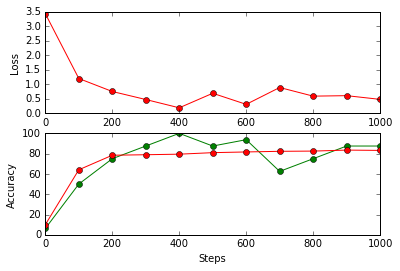

Test accuracy: 89.9%


In [11]:
num_steps = 1001
steps = []
train_loss = []
train_acc = []
val_acc = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      t_acc = accuracy(predictions, batch_labels)
      v_acc = accuracy(valid_prediction.eval(), valid_labels)
      print("Minibatch accuracy: %.1f%%" % t_acc)
      print("Validation accuracy: %.1f%%" % v_acc)
      steps += [step]
      train_loss += [l]
      train_acc += [t_acc]
      val_acc += [v_acc]
      
  displayTrainCurves(steps, train_loss, train_acc, val_acc)
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [14]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph2 = tf.Graph()

with graph2.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    conv = tf.nn.max_pool(conv, [1,2,2,1], [1,2,2,1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
    conv = tf.nn.max_pool(conv, [1,2,2,1], [1,2,2,1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 4.650154
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 100: 1.427522
Minibatch accuracy: 43.8%
Validation accuracy: 53.7%
Minibatch loss at step 200: 1.033035
Minibatch accuracy: 62.5%
Validation accuracy: 76.3%
Minibatch loss at step 300: 0.424669
Minibatch accuracy: 87.5%
Validation accuracy: 80.4%
Minibatch loss at step 400: 0.241723
Minibatch accuracy: 100.0%
Validation accuracy: 80.7%
Minibatch loss at step 500: 0.714662
Minibatch accuracy: 75.0%
Validation accuracy: 81.5%
Minibatch loss at step 600: 0.383380
Minibatch accuracy: 87.5%
Validation accuracy: 82.5%
Minibatch loss at step 700: 0.572957
Minibatch accuracy: 68.8%
Validation accuracy: 81.4%
Minibatch loss at step 800: 0.584339
Minibatch accuracy: 75.0%
Validation accuracy: 83.6%
Minibatch loss at step 900: 0.613463
Minibatch accuracy: 81.2%
Validation accuracy: 84.0%
Minibatch loss at step 1000: 0.428560
Minibatch accuracy: 87.5%
Validation accuracy: 84.1%

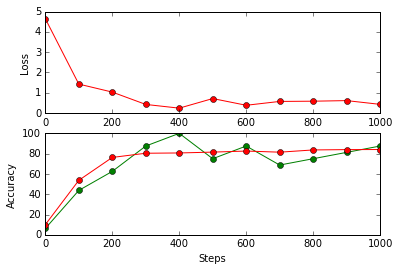

Test accuracy: 90.6%


In [15]:
num_steps = 1001
steps = []
train_loss = []
train_acc = []
val_acc = []

with tf.Session(graph=graph2) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      t_acc = accuracy(predictions, batch_labels)
      v_acc = accuracy(valid_prediction.eval(), valid_labels)
      print("Minibatch accuracy: %.1f%%" % t_acc)
      print("Validation accuracy: %.1f%%" % v_acc)
      steps += [step]
      train_loss += [l]
      train_acc += [t_acc]
      val_acc += [v_acc]
      
  displayTrainCurves(steps, train_loss, train_acc, val_acc)
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [64]:
batch_size = 128

conv1_depth = 16
conv1_ksize = 5
conv1_stride = 1

pool1_ksize = 2
pool1_stride = 2

conv2_depth=24
conv2_ksize = 5
conv2_stride = 1

conv3_depth=32
conv3_ksize = 3
conv3_stride = 1

pool2_ksize = 2
pool2_stride = 2

fc1_size = 512

fc2_size = 64

'''
beta = 0.001
lr_init = 0.1
lr_decay = 0.95
decay_steps = 100
'''
dimRed = conv1_stride * conv2_stride * conv3_stride * pool1_stride * pool2_stride

def getStd(sz):
    return math.sqrt(2.0/sz)

graph3 = tf.Graph()

with graph3.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  conv1_weights = tf.Variable(tf.truncated_normal(
      [conv1_ksize, conv1_ksize, num_channels, conv1_depth], stddev=0.1))
  conv1_biases = tf.Variable(tf.zeros([conv1_depth]))
  conv2_weights = tf.Variable(tf.truncated_normal(
      [conv2_ksize, conv2_ksize, conv1_depth, conv2_depth], stddev=0.1))
  conv2_biases = tf.Variable(tf.constant(1.0, shape=[conv2_depth]))
  conv3_weights = tf.Variable(tf.truncated_normal(
      [conv3_ksize, conv3_ksize, conv2_depth, conv3_depth], stddev=0.1))
  conv3_biases = tf.Variable(tf.constant(1.0, shape=[conv3_depth]))
  inpSize = image_size // dimRed * image_size // dimRed * conv3_depth
  fc1_weights = tf.Variable(tf.truncated_normal(
      [inpSize, fc1_size], stddev=getStd(inpSize)))
  fc1_biases = tf.Variable(tf.constant(1.0, shape=[fc1_size]))
  fc2_weights = tf.Variable(tf.truncated_normal(
      [fc1_size, fc2_size], stddev=getStd(fc1_size)))
  fc2_biases = tf.Variable(tf.constant(1.0, shape=[fc2_size]))
  fc3_weights = tf.Variable(tf.truncated_normal(
      [fc2_size, num_labels], stddev=getStd(fc2_size)))
  fc3_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data, is_train=False):
    conv1 = tf.nn.conv2d(data, conv1_weights, [1, conv1_stride, conv1_stride, 1], padding='SAME')
    conv1 = tf.nn.elu(conv1 + conv1_biases)
    pool1 = tf.nn.max_pool(conv1, [1,pool1_ksize,pool1_ksize,1], [1,pool1_stride,pool1_stride,1], padding='SAME')
    
    conv2 = tf.nn.conv2d(pool1, conv2_weights, [1, conv2_stride, conv2_stride, 1], padding='SAME')
    conv2 = tf.nn.elu(conv2 + conv2_biases)
    
    conv3 = tf.nn.conv2d(conv2, conv3_weights, [1, conv3_stride, conv3_stride, 1], padding='SAME')
    conv3 = tf.nn.elu(conv3 + conv3_biases)
    
    pool2 = tf.nn.max_pool(conv3, [1,pool2_ksize,pool2_ksize,1], [1,pool2_stride,pool2_stride,1], padding='SAME')
    
    shape = pool2.get_shape().as_list()
    pool2_flat = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    fc1 = tf.nn.elu(tf.matmul(pool2_flat, fc1_weights) + fc1_biases)
    fc2 = tf.nn.elu(tf.matmul(fc1, fc2_weights) + fc2_biases)
    if is_train:
      fc2 = tf.nn.dropout(fc2, 0.5)
    return tf.matmul(fc2, fc3_weights) + fc3_biases
  
  # Training computation.
  logits = model(tf_train_dataset, True)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

  #reg = tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc2_weights) 
  #loss += beta * reg
  '''
  # Optimizer: set up a variable that's incremented once per batch and
  # controls the learning rate decay.
  global_step = tf.Variable(0)
  # Decay once per epoch, using an exponential schedule starting at 0.01.
  learning_rate = tf.train.exponential_decay(
      lr_init,                
      global_step, 
      decay_steps,          
      lr_decay,                
      staircase=True)
    
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  '''
  optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(model(tf_train_dataset))
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 7.089400
Minibatch accuracy: 10.2%
Validation accuracy: 10.4%
Minibatch loss at step 100: 0.756792
Minibatch accuracy: 79.7%
Validation accuracy: 81.8%
Minibatch loss at step 200: 0.737549
Minibatch accuracy: 86.7%
Validation accuracy: 84.1%
Minibatch loss at step 300: 0.766940
Minibatch accuracy: 81.2%
Validation accuracy: 85.1%
Minibatch loss at step 400: 0.531071
Minibatch accuracy: 85.2%
Validation accuracy: 85.3%
Minibatch loss at step 500: 0.371768
Minibatch accuracy: 90.6%
Validation accuracy: 87.0%
Minibatch loss at step 600: 0.552189
Minibatch accuracy: 87.5%
Validation accuracy: 87.1%
Minibatch loss at step 700: 0.540132
Minibatch accuracy: 85.9%
Validation accuracy: 87.2%
Minibatch loss at step 800: 0.357449
Minibatch accuracy: 91.4%
Validation accuracy: 87.6%
Minibatch loss at step 900: 0.466697
Minibatch accuracy: 88.3%
Validation accuracy: 87.8%
Minibatch loss at step 1000: 0.598957
Minibatch accuracy: 85.2%
Validation accuracy: 88.2%

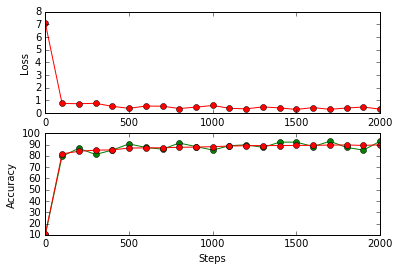

Test accuracy: 95.6%


In [65]:
num_steps = 2001
steps = []
train_loss = []
train_acc = []
val_acc = []

with tf.Session(graph=graph3) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      t_acc = accuracy(predictions, batch_labels)
      v_acc = accuracy(valid_prediction.eval(), valid_labels)
      print("Minibatch accuracy: %.1f%%" % t_acc)
      print("Validation accuracy: %.1f%%" % v_acc)
      steps += [step]
      train_loss += [l]
      train_acc += [t_acc]
      val_acc += [v_acc]
      
  displayTrainCurves(steps, train_loss, train_acc, val_acc)
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))